In [29]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import pytesseract
import mysql.connector
from mysql.connector import Error
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from skimage import io, color, morphology
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split



In [30]:
def straighten_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Apply Hough Line Transform to detect lines in the image
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    # Calculate the angle of the skew
    if lines is not None:
        angles = []
        for line in lines:
            rho, theta = line[0]
            angle = np.degrees(theta)
            if angle > 45:
                angle -= 90
            angles.append(angle)
        
        # Find the median angle of the lines detected
        skew_angle = np.median(angles)
    else:
        skew_angle = 0  # No lines detected, assume no skew

    # Get the dimensions of the image
    (h, w) = image.shape[:2]
    
    # Calculate the center of the image
    center = (w // 2, h // 2)
    
    # Calculate the rotation matrix to correct the skew
    M = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
    
    # Rotate the image to straighten it
    straightened = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return straightened

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def extract_and_segment_characters(image):
    # Convert to grayscale
#     image=cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blurring
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Extract the number plate region
    number_plate = image[y:y+h, x:x+w]
    #number_plate = straighten_image(number_plate)
    number_plate = cv2.resize(number_plate, (900, 300))
    
    # Convert the number plate region to grayscale
    number_plate_gray = cv2.cvtColor(number_plate, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to the number plate region
    thresh = cv2.adaptiveThreshold(number_plate_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)
    
    # Find contours in the thresholded number plate region
    char_contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on size and aspect ratio
    filtered_contours = []
    for contour in char_contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if 0.2 < aspect_ratio < 1.0 and 1000 < cv2.contourArea(contour):
            filtered_contours.append((x,contour))
            cv2.rectangle(number_plate, (x, y), (x + w, y + h), (0, 255, 0), 2)
    filtered_contours.sort(key=lambda k: k[0])
    return number_plate, filtered_contours

def preprocess_char_img(char_img):
    if char_img.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
        char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
    char_img = cv2.resize(char_img, (28, 28))  # Resize to match the input shape of the CNN model
    char_img = char_img / 255.0  # Normalize to [0, 1]
    char_img = np.expand_dims(char_img, axis=-1)  # Add channel dimension (28, 28, 1)
    char_img = np.expand_dims(char_img, axis=0)  # Add batch dimension (1, 28, 28, 1)
    return char_img

def predict(file_name):
    model_alpha=tf.keras.models.load_model('C:/Users/Parth/ocr.h5')
    image = cv2.imread(file_name)

    # Extract and segment characters
    number_plate, fc = extract_and_segment_characters(image)

    # Display the extracted number plate
    plt.imshow(cv2.cvtColor(number_plate, cv2.COLOR_BGR2RGB))
    plt.title('Extracted Number Plate')
    plt.axis('off')
    plt.show()


    recognized_text = ''
    recognized_text1 = ''

    char_contours=[]
    for i in  fc:
        char_contours.append(i[1])
    for i, contour in enumerate(char_contours):
        x, y, w, h = cv2.boundingRect(contour)
        char_img = number_plate[y-10:y+h+20, x-5:x+w+5]
#         char_img = straighten_image(char_img)
        char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        _, char_img = cv2.threshold(char_img, 145, 255, cv2.THRESH_BINARY)
        char_img = preprocess_char_img(char_img)  # Preprocess the character image
        # Predict the character using the CNN model
        prediction = model_alpha.predict(char_img)
        f=0
        if ((0<=i<=1 or 4<=i<=5) and len(char_contours)==10) or ((0<=i<=1 or 3<=i<=4) and len(char_contours)==9):
            recognized_char_index = np.argmax(prediction[0][0:26])  # Get the index of the highest probability
        else:
            recognized_char_index = np.argmax(prediction[0][26:])
            f=1
        if f==1:
            recognized_char = str(recognized_char_index)  # For digits 0-9
        else:
            recognized_char = chr(65 + recognized_char_index)  # For letters A-Z

        recognized_text += recognized_char if recognized_char else '?'
    print("Recognized Text:", recognized_text)
    return recognized_text



In [32]:
import mysql.connector
from mysql.connector import Error
def create_server_connection(host_name, user_name, user_password):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")
def read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")

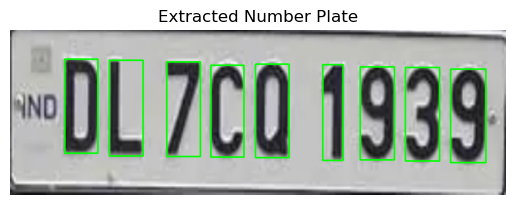

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Recognized Text: DL7CQ1939
Welcome Ram


In [33]:
np=predict('car.webp')

connection = mysql.connector.connect(
host="localhost",
user="root",
password="1234",
database="numberplate")
cursor = connection.cursor()

select_query = """
    SELECT *
    FROM numberplate
    where number_plate=%s;
    """
values = (np,)
cursor.execute(select_query,values )
# Fetch the results
results = cursor.fetchall()
if len(results)==1:
    print("Welcome", results[0][1])
else:
    print("Invalid Login Credentials")